In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#set paths for file navigation
BASE_DIR = pathlib.Path().resolve().parent
DATA_DIR = BASE_DIR / 'data'

In [3]:
top_churn = DATA_DIR / 'processed/Top churners.csv' #dataset containing numbers for churn
org_details = DATA_DIR / 'processed/non-zero earners.csv' #dataset containing details for paying orgs

In [4]:
df_top_churn = pd.read_csv(top_churn)
df_top_churn.head(5)

,organization_id,times_churned,times_reactivated,times_retained,revenue
0,4155886,5,5,0,50.0
1,4337488,4,3,0,30.0
2,4026795,4,4,4,1110.0
3,4235917,3,2,1,29.0
4,4364720,3,2,2,80.0


In [5]:
#get all the categorical variables
cat_vars = [var for var in df_top_churn.columns if df_top_churn[var].dtype == 'O']

#we have to add org_id and org_owner_id as they are also categorical
cat_vars = cat_vars + ['organization_id']

#cast all categorical variables to dtype object
df_top_churn[cat_vars] = df_top_churn[cat_vars].astype('O')

In [6]:
df_top_churn.describe()

,times_churned,times_reactivated,times_retained,revenue
count,25166.000000,25166.000000,25166.000000,25166.000000
mean,0.268378,0.038703,8.202535,544.532238
std,0.455506,0.205846,4.473134,1544.805694
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4.000000,72.000000
50%,0.000000,0.000000,11.000000,120.000000
75%,1.000000,0.000000,12.000000,495.000000
max,5.000000,5.000000,12.000000,79612.900000


I see an outlier in terms of revenue, which brings up an interesting point. Why would a organization who seemingly likes the product churn multiple times? Let's get a list of these orgs.

In [7]:
#filter for orgs which churned twice or more
df_frequent_churners = df_top_churn[df_top_churn['times_churned'] >= 2]

In [8]:
df_frequent_churners.describe()

,times_churned,times_reactivated,times_retained,revenue
count,109.000000,109.000000,109.000000,109.000000
mean,2.119266,1.357798,4.183486,252.651376
std,0.445653,0.687493,2.867975,375.524498
min,2.000000,1.000000,0.000000,10.000000
25%,2.000000,1.000000,2.000000,50.000000
50%,2.000000,1.000000,4.000000,80.000000
75%,2.000000,2.000000,6.000000,307.200000
max,5.000000,5.000000,9.000000,2052.000000


In [9]:
#view orgs which have high revenue
df_frequent_churners.sort_values('revenue', ascending=False)

,organization_id,times_churned,times_reactivated,times_retained,revenue
85,29046,2,1,8,2052.0
84,4194749,2,1,9,1850.0
78,4579431,2,1,7,1660.0
2,4026795,4,4,4,1110.0
106,4399724,2,2,1,1083.0
...,...,...,...,...,...
62,4715335,2,1,0,20.0
47,4069950,2,1,0,10.0
38,4860453,2,1,0,10.0
36,4009156,2,1,0,10.0


In [10]:
sns.set_theme(style='darkgrid', palette='colorblind')

<AxesSubplot:xlabel='times_churned', ylabel='revenue'>

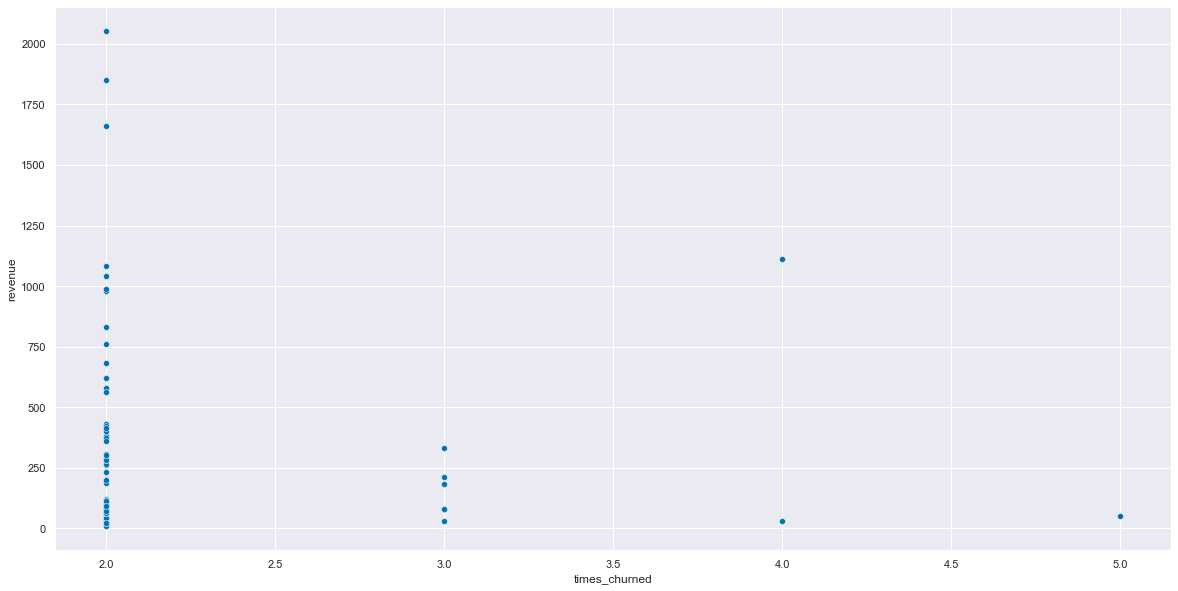

In [11]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_frequent_churners, x='times_churned', y='revenue')

In [12]:
#get list of orgs who churned frequently and had high revenue, save it for later analysis
df_churn_orgs_interest = df_frequent_churners[(df_frequent_churners['times_churned'] >= 2) & (df_frequent_churners['revenue'] > 300)].sort_values('revenue', ascending=False)

Now let's explore these organizations! Maybe we can find a pattern or common characteristic that could help us with churn.

In [13]:
#read in dataset containing org details
df_orgs = pd.read_csv(org_details)

#filter to obtain details of the organizations of interest
df_churn_orgs_interest_details = (
    df_churn_orgs_interest.merge(df_orgs, 
              on=['organization_id'],        #join on organization_id
              how='left',                    #left join to check if any org details are missing
              indicator=True)
)

df_churn_orgs_interest_details.query('_merge == "left_only"')

,organization_id,times_churned,times_reactivated,times_retained,revenue,organization_owner_id,total_revenue_2021,revenue_realized_to_date_usd,time_entries_count,billable_time_entries_count,...,billable_hours_tracked,clients_used,projects_used,billable_projects_used,country,industry,company_type,approximate_employees,reported_annual_revenue,_merge
9,2584442,2,2,8,760.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
21,4040055,2,1,6,400.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [14]:
df_churn_orgs_interest_details.head(5)

,organization_id,times_churned,times_reactivated,times_retained,revenue,organization_owner_id,total_revenue_2021,revenue_realized_to_date_usd,time_entries_count,billable_time_entries_count,...,billable_hours_tracked,clients_used,projects_used,billable_projects_used,country,industry,company_type,approximate_employees,reported_annual_revenue,_merge
0,29046,2,1,8,2052.0,5876597.0,2052.0,3168.0,17225.0,10572.0,...,10342.437500,92.0,312.0,305.0,United States,Internet Software & Services,public,865406.0,3.860640e+11,both
1,4194749,2,1,9,1850.0,1625595.0,1850.0,7686.0,119556.0,94382.0,...,74868.274167,351.0,4446.0,4427.0,Poland,Media,private,30.0,NaN,both
2,4579431,2,1,7,1660.0,6064941.0,1660.0,1900.0,2396.0,2141.0,...,4882.580833,1.0,38.0,31.0,United States,NaN,private,10.0,NaN,both
3,4026795,4,4,4,1110.0,4483851.0,1110.0,3240.0,13606.0,13109.0,...,15085.404444,2.0,17.0,17.0,Georgia,NaN,NaN,NaN,NaN,both
4,4399724,2,2,1,1083.0,4999831.0,1083.0,1273.0,12508.0,3673.0,...,1999.409444,398.0,488.0,262.0,United States,Internet Software & Services,private,420.0,NaN,both


Text(0, 0.5, 'Count')

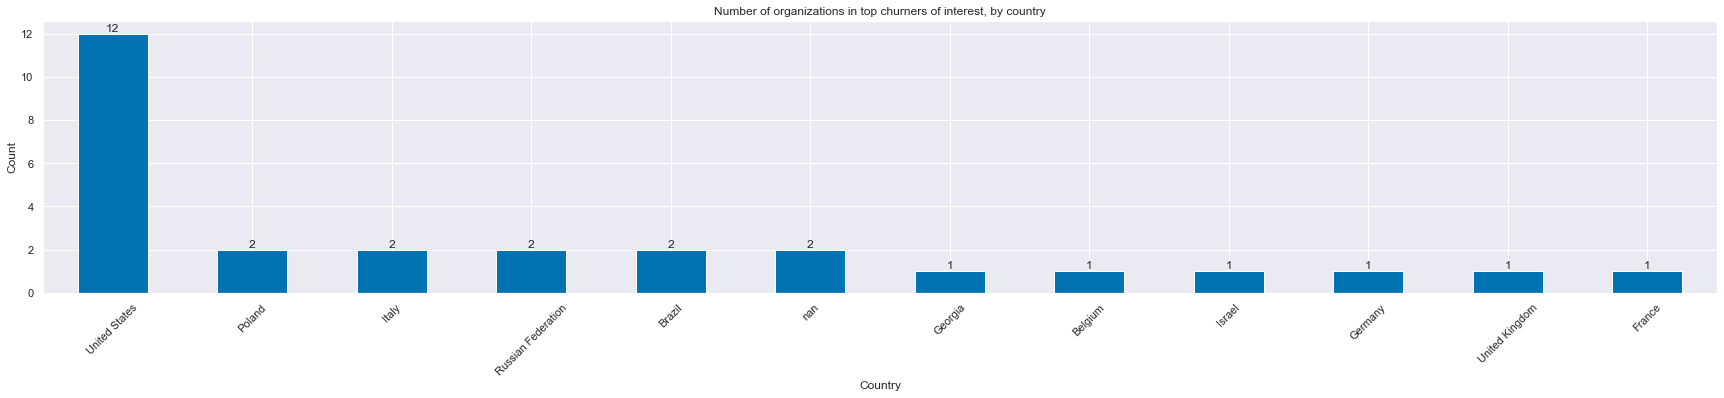

In [15]:
plt.figure(figsize=(30,5))
fig = df_churn_orgs_interest_details['country'].value_counts(dropna=False).plot(kind='bar')
fig.bar_label(fig.containers[0])
plt.title('Number of organizations in top churners of interest, by country')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Count')

Text(0, 0.5, 'Count')

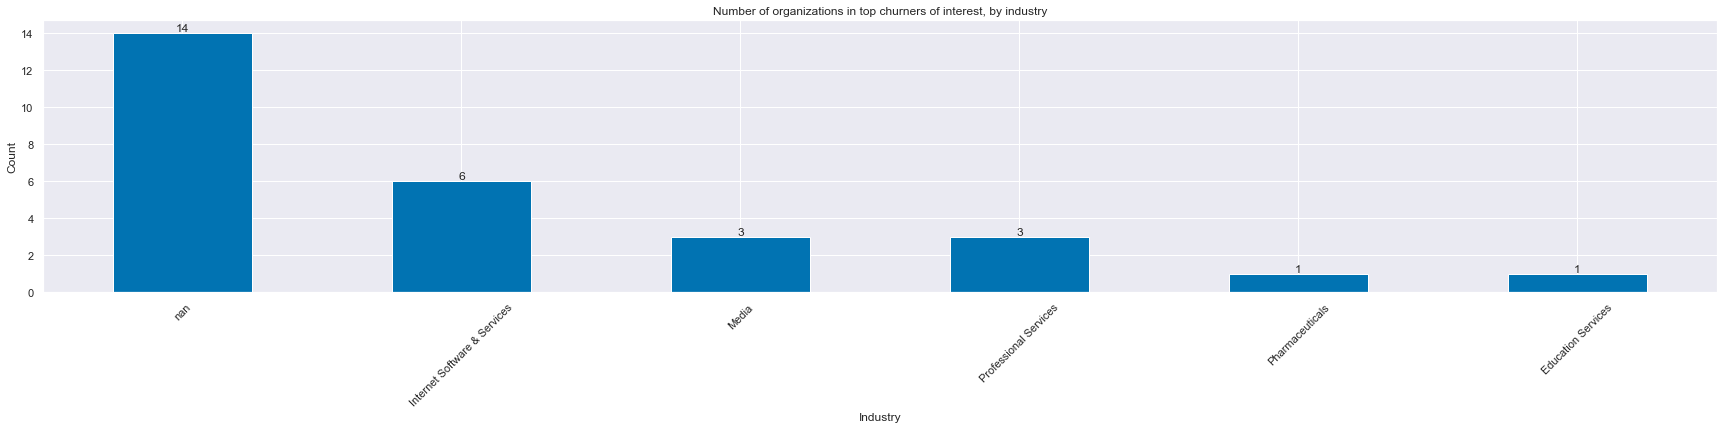

In [16]:
plt.figure(figsize=(30,5))
fig = df_churn_orgs_interest_details['industry'].value_counts(dropna=False).plot(kind='bar')
fig.bar_label(fig.containers[0])
plt.title('Number of organizations in top churners of interest, by industry')
plt.xlabel('Industry')
plt.xticks(rotation=45)
plt.ylabel('Count')

Text(0, 0.5, 'Count')

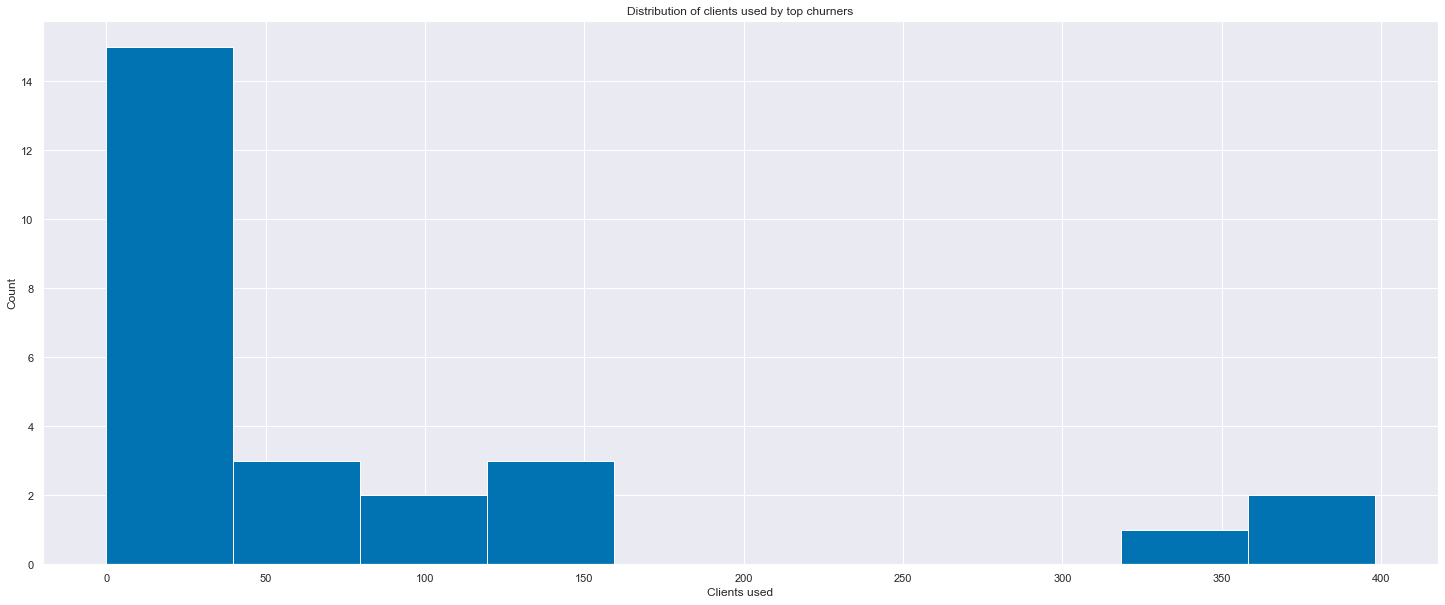

In [17]:
plt.figure(figsize=(25,10))
fig = df_churn_orgs_interest_details['clients_used'].plot(kind='hist')
plt.title('Distribution of clients used by top churners')
plt.xlabel('Clients used')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

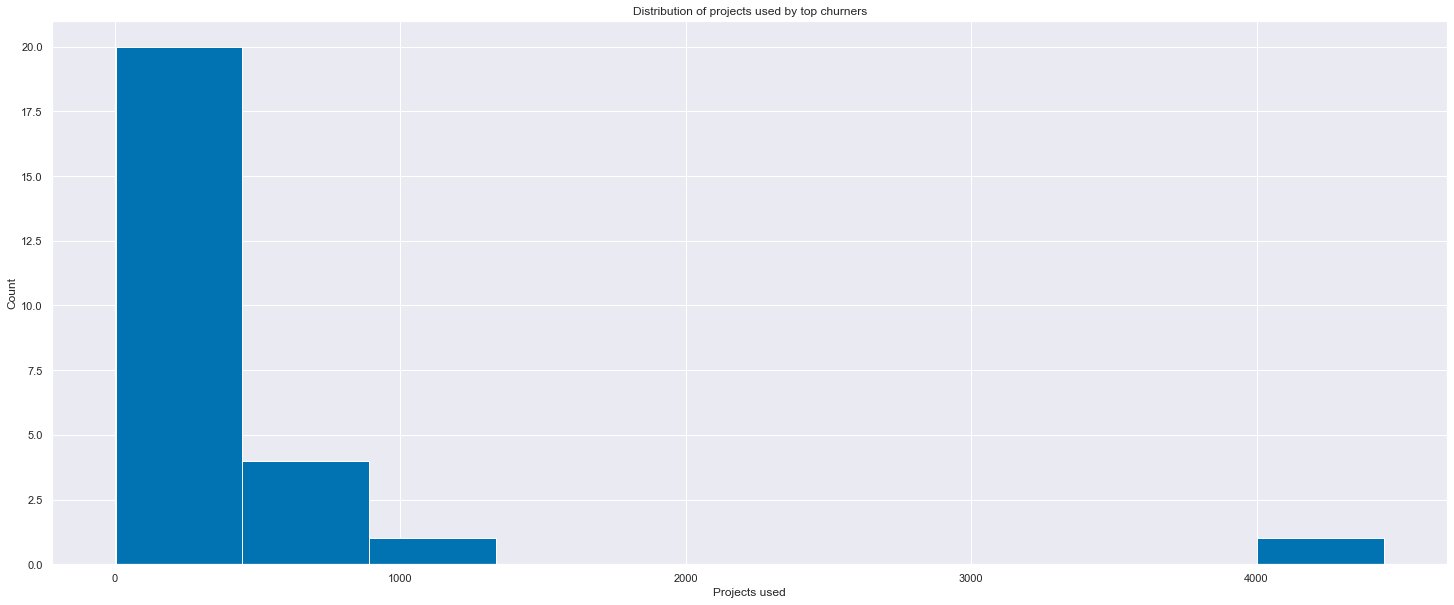

In [18]:
plt.figure(figsize=(25,10))
fig = df_churn_orgs_interest_details['projects_used'].plot(kind='hist')
plt.title('Distribution of projects used by top churners')
plt.xlabel('Projects used')
plt.ylabel('Count')

Create a few columns for percentage of billable hours/entries. I want to see if it is the case that high churners are not finding much use out of the service.

In [19]:
df_churn_orgs_interest_details['pct_billable_time_entries'] = df_churn_orgs_interest_details['billable_time_entries_count']/df_churn_orgs_interest_details['time_entries_count']
df_churn_orgs_interest_details['pct_billable_hours_tracked'] = df_churn_orgs_interest_details['billable_hours_tracked']/df_churn_orgs_interest_details['hours_tracked']
df_churn_orgs_interest_details['pct_billable_projects_used'] = df_churn_orgs_interest_details['billable_projects_used']/df_churn_orgs_interest_details['projects_used']

Text(0, 0.5, 'Count')

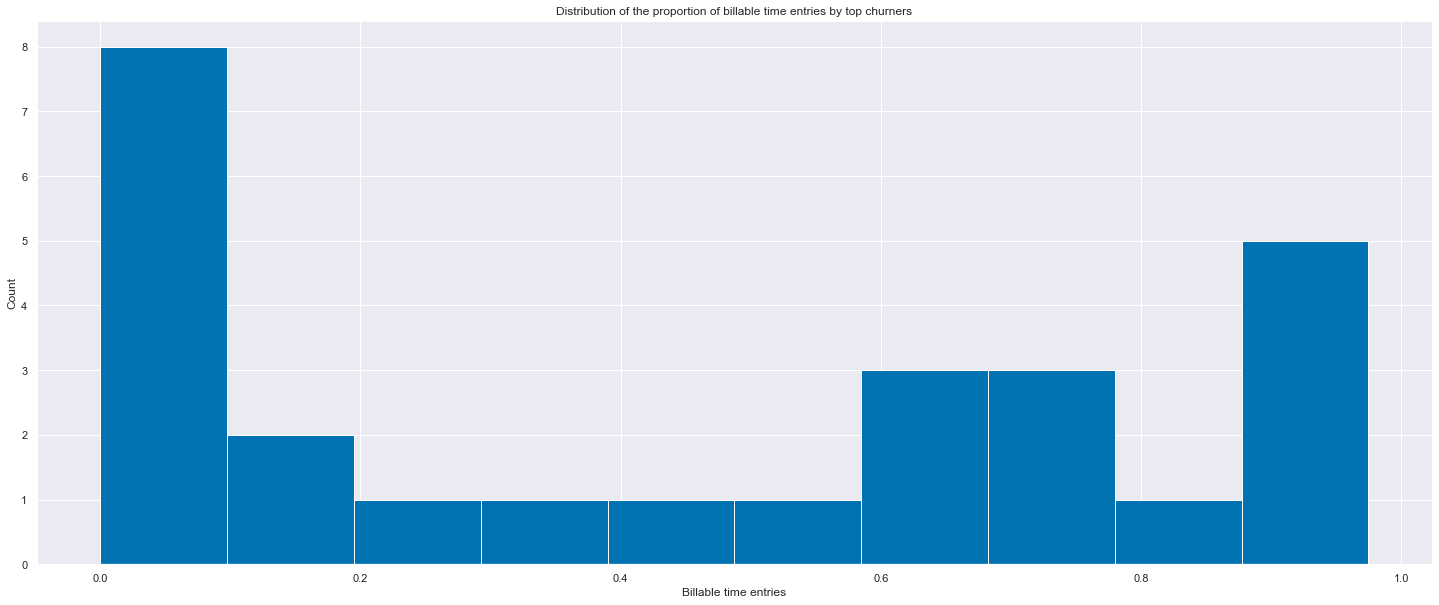

In [20]:
plt.figure(figsize=(25,10))
fig = df_churn_orgs_interest_details['pct_billable_time_entries'].plot(kind='hist')
plt.title('Distribution of the proportion of billable time entries by top churners')
plt.xlabel('Billable time entries')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

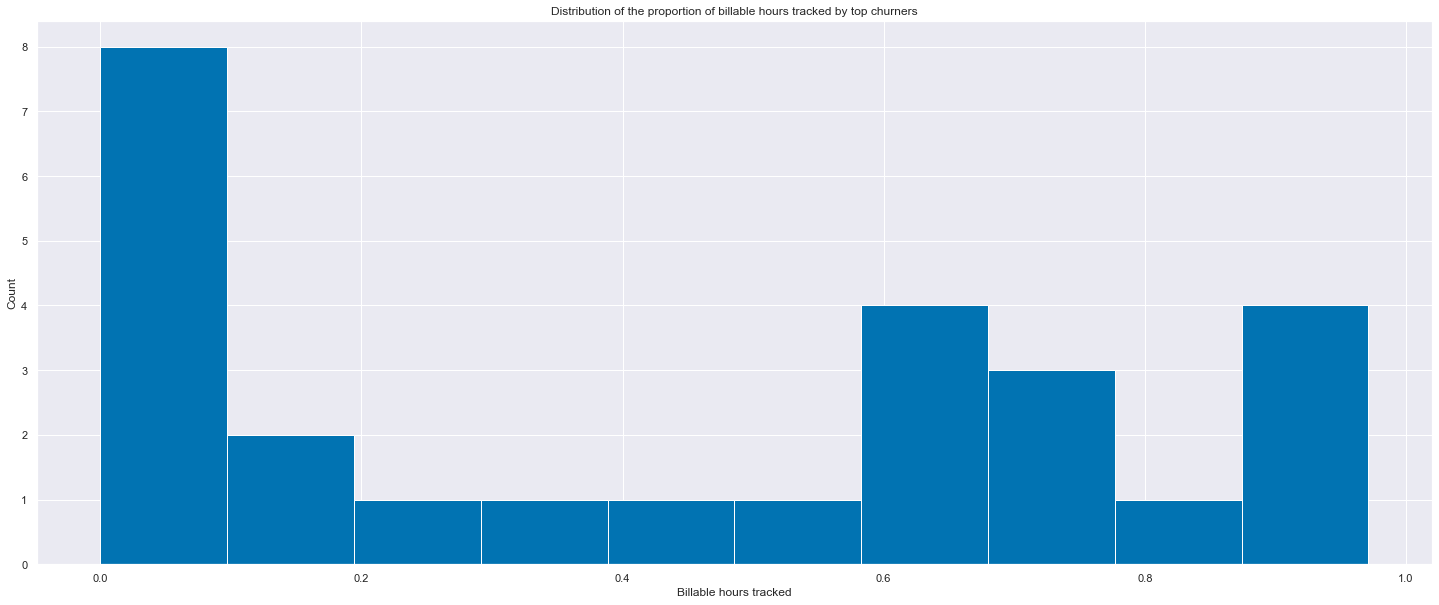

In [21]:
plt.figure(figsize=(25,10))
fig = df_churn_orgs_interest_details['pct_billable_hours_tracked'].plot(kind='hist')
plt.title('Distribution of the proportion of billable hours tracked by top churners')
plt.xlabel('Billable hours tracked')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

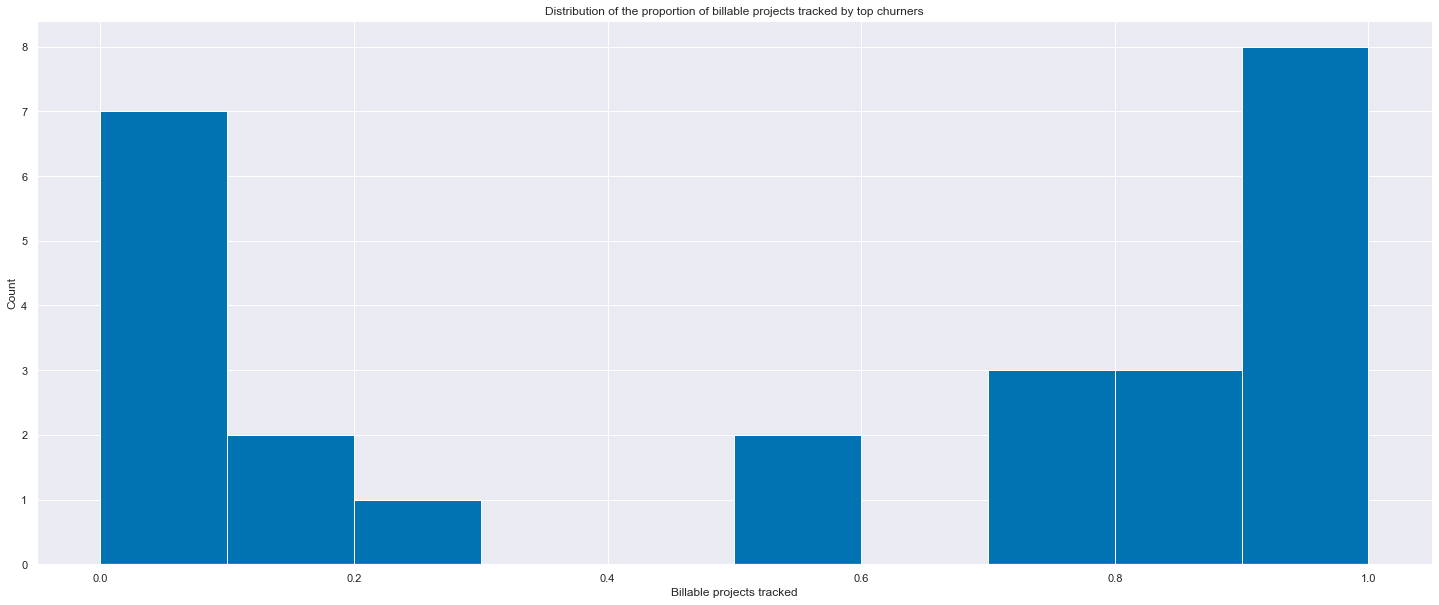

In [22]:
plt.figure(figsize=(25,10))
fig = df_churn_orgs_interest_details['pct_billable_projects_used'].plot(kind='hist')
plt.title('Distribution of the proportion of billable projects tracked by top churners')
plt.xlabel('Billable projects tracked')
plt.ylabel('Count')